In [254]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.losses import mean_squared_error as mse

from tensorflow.linalg import expm,logm

In [2]:
from numpy.random import multivariate_normal as mvn

from scipy.linalg import expm as expm
from scipy.linalg import logm as logm

In [3]:
sess = tf.InteractiveSession()

### Load Data 

In [4]:
from scipy.io import loadmat
data_train = loadmat('data/sarcos_inv.mat')
data_test = loadmat('data/sarcos_inv_test.mat')

x_train = data_train['sarcos_inv'][:,:21]
y_train = data_train['sarcos_inv'][:,21:22]
y_var = np.var(y_train)

x_test = data_test['sarcos_inv_test'][:,:21]
y_test = data_test['sarcos_inv_test'][:,21:22]

### Standard Linear Regression

In [5]:
X  = np.hstack([np.ones((x_train.shape[0],1)), x_train])
Y = y_train.copy()
lamda = 0.00001
w = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)+lamda*np.eye(X.shape[1])),X.T),Y)

y_pred = np.dot(np.hstack([np.ones((x_train.shape[0],1)), x_train]), w)
smse_train = (mean_squared_error(y_pred,y_train))/y_var
y_pred = np.dot(np.hstack([np.ones((x_test.shape[0],1)), x_test]), w)
smse_test = (mean_squared_error(y_pred,y_test))/y_var

print smse_train,smse_test

0.07358881422797761 0.0742260930366048


In [6]:
w_standard = w.copy()

### Bayesian Linear Regression 

### Generate simple dataset 

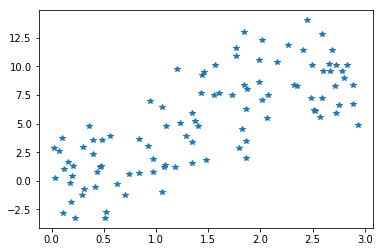

In [523]:
N=100
X = np.hstack([np.ones((N,1)), 3*np.random.rand(N,1)])#, 3*np.random.rand(N,1), 2*np.random.rand(N,1), \
#           3*np.random.rand(N,1), 3*np.random.rand(N,1), 2*np.random.rand(N,1), \
#              3*np.random.rand(N,1), 3*np.random.rand(N,1), 2*np.random.rand(N,1), \
#              3*np.random.rand(N,1), 3*np.random.rand(N,1), 2*np.random.rand(N,1), \
#              3*np.random.rand(N,1), 3*np.random.rand(N,1), 2*np.random.rand(N,1)])#,
#             3*np.random.rand(N,1), 3*np.random.rand(N,1), 2*np.random.rand(N,1),
#              3*np.random.rand(N,1), 3*np.random.rand(N,1), 2*np.random.rand(N,1)]) 
D = X.shape[1]
w_true = 3*np.random.normal(size=[D,1])
Y = np.dot(X,w_true) + 3*np.random.normal(size=[N,1])
plt.plot(X[:,1],Y,'*')

In [524]:
from math import e

In [525]:
def posterior(w, params, X, Y):
    alpha = params[0]
    lamda = params[1]
    n = X.shape[0]
    val = (n+1)*tf.log(2*np.pi) + n*tf.log(lamda) + tf.log(alpha) + 0.5*(tf.matmul(tf.transpose(w),w))
    val = -0.5*tf.matmul(tf.transpose(Y-tf.matmul(X,w)), Y-tf.matmul(X,w))/lamda
    return val

In [526]:
def ELBO(mu,L,samples, params, X, Y):
    d = int(samples.shape[1])
    n = int(samples.shape[0])
    val = 0.5*d*(tf.log(2*np.pi)+1) + tf.trace(L)
    L_sym = 0.5*(L+tf.transpose(L))
    for i in range(samples.shape[0]):
        val -= posterior(mu + tf.matmul(expm(L_sym),tf.transpose(samples[i:i+1])), params, X, Y)/n
    return val

In [527]:
alpha = 10000.
lamda = 1.
params = [alpha,lamda]
D_in = X.shape[1]
D_out = 1
batch_size = 50
mu_0 = np.random.rand(D_in,1).astype(np.float32)
L_0 = np.eye(D_in).astype(np.float32)

mu = tf.Variable(mu_0.copy())
L = tf.Variable(L_0.copy())

X = X.astype(np.float32)
Y = Y.astype(np.float32)

error_mse = mse(tf.matmul(X,mu),Y)
post = posterior(mu,params,X,Y)

samples = tf.placeholder(tf.float32,shape=(batch_size, D_in))

In [528]:
elbo = ELBO(mu,L,samples, params, X, Y)
tf.gradients(elbo,[mu,L])

[<tf.Tensor 'gradients_48/AddN_428:0' shape=(2, 1) dtype=float32>,
 <tf.Tensor 'gradients_48/AddN_602:0' shape=(2, 2) dtype=float32>]

In [529]:
optimizer = tf.train.AdamOptimizer(0.1)
train = optimizer.minimize(elbo,var_list=[mu,L])

sess.run(tf.global_variables_initializer())

In [530]:
for i in range(3000):
    cur_samples = np.array([np.random.normal(np.zeros(D_in)) for j in range(batch_size)])
    _,val,elbo_,mu_,e_ = sess.run([train,post, elbo,mu,error_mse],feed_dict={samples:cur_samples})
    print i,val,elbo_,e_

0 [[-2025.5809]] [[3141.792]] 40.51162
1 [[-1882.7435]] [[2933.878]] 37.654873
2 [[-1747.1945]] [[2214.8088]] 34.943897
3 [[-1618.9171]] [[2188.5557]] 32.37834
4 [[-1497.6833]] [[1730.5905]] 29.953674
5 [[-1383.6477]] [[1789.1545]] 27.67295
6 [[-1276.8809]] [[1736.0526]] 25.537624
7 [[-1176.5856]] [[1750.5237]] 23.53171
8 [[-1082.7047]] [[1393.3328]] 21.654089
9 [[-996.4954]] [[1320.2534]] 19.92991
10 [[-917.7498]] [[1115.4072]] 18.354996
11 [[-846.6507]] [[980.0176]] 16.933014
12 [[-783.00366]] [[872.4315]] 15.660069
13 [[-726.29095]] [[879.77356]] 14.525822
14 [[-676.10986]] [[748.8662]] 13.522194
15 [[-632.3852]] [[697.6063]] 12.647704
16 [[-594.78284]] [[718.2667]] 11.895658
17 [[-562.6759]] [[662.5999]] 11.253517
18 [[-535.6722]] [[623.11676]] 10.713446
19 [[-513.40594]] [[622.59784]] 10.26812
20 [[-495.40945]] [[537.2502]] 9.908189
21 [[-481.46924]] [[556.3821]] 9.629384
22 [[-470.91803]] [[512.0726]] 9.418361
23 [[-463.40335]] [[514.2832]] 9.268065
24 [[-458.42303]] [[533.0097]]

216 [[-380.68527]] [[382.56613]] 7.6137037
217 [[-380.67868]] [[383.21683]] 7.613573
218 [[-380.67368]] [[382.85495]] 7.6134753
219 [[-380.67072]] [[383.54913]] 7.6134157
220 [[-380.66867]] [[382.3422]] 7.61337
221 [[-380.66556]] [[382.90582]] 7.613313
222 [[-380.66248]] [[383.02933]] 7.6132507
223 [[-380.65765]] [[382.6854]] 7.6131544
224 [[-380.65097]] [[382.55267]] 7.6130195
225 [[-380.64493]] [[383.22507]] 7.6128983
226 [[-380.63757]] [[382.06537]] 7.6127534
227 [[-380.63193]] [[383.43243]] 7.612639
228 [[-380.627]] [[382.58292]] 7.6125402
229 [[-380.62317]] [[382.8572]] 7.6124635
230 [[-380.61987]] [[381.88654]] 7.612399
231 [[-380.61743]] [[382.9794]] 7.6123476
232 [[-380.6152]] [[382.3749]] 7.612306
233 [[-380.61417]] [[382.65698]] 7.612283
234 [[-380.61276]] [[382.22772]] 7.612254
235 [[-380.61115]] [[382.999]] 7.6122227
236 [[-380.60886]] [[383.39832]] 7.6121764
237 [[-380.60593]] [[382.07495]] 7.612119
238 [[-380.60257]] [[382.567]] 7.61205
239 [[-380.59888]] [[382.63083]] 7.

417 [[-380.56415]] [[379.4284]] 7.611283
418 [[-380.56482]] [[379.47705]] 7.611296
419 [[-380.56592]] [[379.461]] 7.6113186
420 [[-380.56622]] [[379.97876]] 7.6113243
421 [[-380.56653]] [[379.64856]] 7.611331
422 [[-380.5659]] [[379.4638]] 7.61132
423 [[-380.56583]] [[379.67184]] 7.6113176
424 [[-380.56598]] [[379.5581]] 7.61132
425 [[-380.56586]] [[379.29306]] 7.6113176
426 [[-380.56607]] [[379.55313]] 7.6113214
427 [[-380.56604]] [[379.60526]] 7.6113214
428 [[-380.5659]] [[380.0839]] 7.6113195
429 [[-380.5655]] [[379.24615]] 7.611311
430 [[-380.56467]] [[379.23236]] 7.611295
431 [[-380.56458]] [[379.2853]] 7.611293
432 [[-380.56476]] [[379.64206]] 7.6112957
433 [[-380.56406]] [[379.25864]] 7.611283
434 [[-380.56372]] [[379.30722]] 7.611274
435 [[-380.56354]] [[379.2589]] 7.6112676
436 [[-380.5632]] [[379.3123]] 7.6112647
437 [[-380.56332]] [[379.36646]] 7.611267
438 [[-380.56384]] [[379.07147]] 7.611278
439 [[-380.56467]] [[379.13147]] 7.611293
440 [[-380.5665]] [[379.54895]] 7.61133

623 [[-380.56445]] [[377.83737]] 7.611289
624 [[-380.56415]] [[377.74542]] 7.611284
625 [[-380.5641]] [[377.73325]] 7.6112823
626 [[-380.56403]] [[377.71356]] 7.6112776
627 [[-380.56415]] [[377.67236]] 7.6112823
628 [[-380.56433]] [[377.65973]] 7.6112847
629 [[-380.56436]] [[377.68744]] 7.611287
630 [[-380.56458]] [[377.8967]] 7.6112914
631 [[-380.5645]] [[377.67654]] 7.6112914
632 [[-380.56467]] [[377.77353]] 7.6112933
633 [[-380.56488]] [[377.64398]] 7.6112976
634 [[-380.56433]] [[377.82297]] 7.611286
635 [[-380.56403]] [[377.83978]] 7.6112785
636 [[-380.5636]] [[377.7077]] 7.611269
637 [[-380.56317]] [[377.69708]] 7.611263
638 [[-380.56354]] [[377.6822]] 7.611271
639 [[-380.56418]] [[377.6965]] 7.6112847
640 [[-380.5657]] [[377.73645]] 7.611313
641 [[-380.56635]] [[377.78983]] 7.6113257
642 [[-380.5678]] [[377.7036]] 7.611355
643 [[-380.56897]] [[377.79153]] 7.61138
644 [[-380.5704]] [[377.6021]] 7.611407
645 [[-380.57224]] [[377.5194]] 7.6114445
646 [[-380.5727]] [[377.59805]] 7.61

830 [[-380.56332]] [[376.15533]] 7.6112647
831 [[-380.56326]] [[376.16498]] 7.6112633
832 [[-380.56314]] [[376.20584]] 7.611265
833 [[-380.56323]] [[376.08514]] 7.611265
834 [[-380.56326]] [[376.107]] 7.611265
835 [[-380.5633]] [[376.1152]] 7.611265
836 [[-380.56323]] [[376.19092]] 7.611265
837 [[-380.56326]] [[376.11346]] 7.6112647
838 [[-380.5631]] [[376.09506]] 7.6112647
839 [[-380.56345]] [[376.09668]] 7.6112695
840 [[-380.5636]] [[376.1171]] 7.611271
841 [[-380.56366]] [[376.08713]] 7.6112757
842 [[-380.5639]] [[376.02487]] 7.611276
843 [[-380.5636]] [[376.08176]] 7.611272
844 [[-380.56363]] [[376.03378]] 7.6112742
845 [[-380.5636]] [[376.0606]] 7.6112742
846 [[-380.56357]] [[376.11124]] 7.61127
847 [[-380.5634]] [[376.056]] 7.611269
848 [[-380.56342]] [[375.98547]] 7.611269
849 [[-380.56335]] [[376.1302]] 7.611269
850 [[-380.56332]] [[376.04446]] 7.611267
851 [[-380.56323]] [[376.05115]] 7.6112657
852 [[-380.56348]] [[375.98004]] 7.6112685
853 [[-380.56375]] [[376.06586]] 7.61127

1047 [[-380.56598]] [[374.4487]] 7.61132
1048 [[-380.56534]] [[374.41727]] 7.611307
1049 [[-380.565]] [[374.46722]] 7.6113005
1050 [[-380.5642]] [[374.42416]] 7.611283
1051 [[-380.5636]] [[374.42313]] 7.611273
1052 [[-380.56326]] [[374.3409]] 7.611264
1053 [[-380.56314]] [[374.38345]] 7.6112623
1054 [[-380.56317]] [[374.4194]] 7.6112633
1055 [[-380.56323]] [[374.31958]] 7.6112647
1056 [[-380.56323]] [[374.3455]] 7.611267
1057 [[-380.56326]] [[374.36523]] 7.611265
1058 [[-380.56317]] [[374.3549]] 7.611263
1059 [[-380.56314]] [[374.3396]] 7.611263
1060 [[-380.5631]] [[374.29288]] 7.6112633
1061 [[-380.5631]] [[374.30017]] 7.611263
1062 [[-380.5632]] [[374.3577]] 7.611264
1063 [[-380.56314]] [[374.24152]] 7.6112623
1064 [[-380.5632]] [[374.2847]] 7.611264
1065 [[-380.56348]] [[374.31073]] 7.6112676
1066 [[-380.56348]] [[374.30835]] 7.6112685
1067 [[-380.56332]] [[374.269]] 7.6112666
1068 [[-380.5633]] [[374.2297]] 7.611265
1069 [[-380.56317]] [[374.25397]] 7.611263
1070 [[-380.56314]] [[3

KeyboardInterrupt: 

### Plot

In [531]:
Sigma = expm(2*L).eval()

[-0.0298096   3.59132463]
[-0.02403353  3.56100919]
[-0.02427942  3.55514359]
[-0.02622881  3.57539319]
[-0.02624145  3.55696627]
[-0.02571565  3.56688475]
[-0.0254003  3.5737699]
[-0.02216594  3.5349704 ]
[-0.02075487  3.52546982]
[-0.02637827  3.58123124]


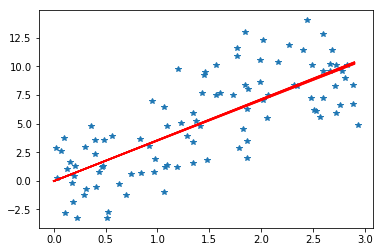

In [532]:
plt.plot(X[:,1],Y,'*')
x_test = np.arange(0,3,0.1)[:,None]
X_test = np.hstack([np.ones((x_test.shape[0],1)),x_test])
for i in range(10):
    sample_mu = mvn(mu_[:,0], Sigma)
    print sample_mu
    y_pred = np.dot(X_test,sample_mu)
    plt.plot(x_test, y_pred, '-r')

### On Project

In [255]:
X  = np.hstack([np.ones((x_train.shape[0],1)), x_train])
Y = y_train.copy()

In [256]:
alpha = 10000.
lamda = 1.
params = [alpha,lamda]
D_in = X.shape[1]
D_out = 1
batch_size = 50
mu_0 = np.random.rand(D_in,1).astype(np.float32)
L_0 = np.eye(D_in).astype(np.float32)

mu = tf.Variable(mu_0.copy())
L = tf.Variable(L_0.copy())

X = X.astype(np.float32)
Y = Y.astype(np.float32)

error_mse = mse(tf.matmul(X,mu),Y)
post = posterior(mu,params,X,Y)

samples = tf.placeholder(tf.float32,shape=(batch_size, D_in))

In [257]:
elbo = ELBO(mu,L,samples, params, X, Y)
tf.gradients(elbo,[mu,L])

optimizer = tf.train.AdamOptimizer(0.01)
train = optimizer.minimize(elbo,var_list=[mu,L])

sess.run(tf.global_variables_initializer())

In [261]:
for i in range(3000):
    cur_samples = np.array([np.random.normal(np.zeros(D_in)) for j in range(batch_size)])
    _,val,elbo_,mu_,e_ = sess.run([train,post, elbo,mu,error_mse],feed_dict={samples:cur_samples})
    print i,val,elbo_,e_

0 [[-726229.8]] [[749752.1]] 32.651283
1 [[-726237.1]] [[748098.4]] 32.65159
2 [[-726163.6]] [[746706.6]] 32.64834
3 [[-726182.44]] [[745743.2]] 32.649143
4 [[-726239.06]] [[747646.]] 32.65168
5 [[-726258.94]] [[744719.06]] 32.652634
6 [[-726207.5]] [[743597.06]] 32.650307
7 [[-726082.2]] [[747181.06]] 32.644627
8 [[-726021.94]] [[749074.25]] 32.641968
9 [[-726026.44]] [[743662.6]] 32.642204
10 [[-725991.9]] [[745042.94]] 32.64058
11 [[-725968.7]] [[744278.4]] 32.63959
12 [[-726027.]] [[742701.1]] 32.642174
13 [[-726187.44]] [[746097.6]] 32.649406
14 [[-726319.94]] [[744337.7]] 32.65534
15 [[-726518.]] [[748256.06]] 32.664238
16 [[-726491.75]] [[747123.9]] 32.663086
17 [[-726327.1]] [[746135.6]] 32.655655
18 [[-726055.5]] [[748063.06]] 32.643448
19 [[-725917.25]] [[744012.6]] 32.63717
20 [[-725947.1]] [[745058.6]] 32.638527
21 [[-726005.06]] [[745453.94]] 32.64116
22 [[-726003.06]] [[744515.1]] 32.641068
23 [[-725931.6]] [[748997.25]] 32.637936
24 [[-725822.56]] [[745099.1]] 32.63297
2

202 [[-724132.8]] [[739857.25]] 32.557
203 [[-724363.7]] [[739411.2]] 32.567398
204 [[-724476.56]] [[742217.06]] 32.572414
205 [[-724253.94]] [[744538.56]] 32.562454
206 [[-723929.2]] [[742192.56]] 32.547874
207 [[-723750.56]] [[743741.4]] 32.539787
208 [[-723812.2]] [[741754.6]] 32.542645
209 [[-724018.94]] [[741459.]] 32.551907
210 [[-724106.06]] [[740566.4]] 32.555847
211 [[-724125.94]] [[742184.56]] 32.556694
212 [[-723912.5]] [[741520.75]] 32.54711
213 [[-723720.7]] [[741480.94]] 32.538483
214 [[-723597.]] [[739720.7]] 32.532898
215 [[-723684.06]] [[742379.8]] 32.5368
216 [[-724015.75]] [[743275.6]] 32.55176
217 [[-724202.7]] [[739325.7]] 32.560127
218 [[-724003.2]] [[739020.6]] 32.55116
219 [[-723831.2]] [[739970.2]] 32.543457
220 [[-723620.6]] [[743052.]] 32.53395
221 [[-723566.6]] [[741135.6]] 32.53153
222 [[-723631.5]] [[739408.2]] 32.534435
223 [[-723705.25]] [[740587.1]] 32.5378
224 [[-723656.8]] [[739616.06]] 32.535587
225 [[-723669.9]] [[738723.6]] 32.536194
226 [[-723606.

405 [[-721654.1]] [[737026.7]] 32.44557
406 [[-721613.4]] [[735164.94]] 32.443703
407 [[-721494.]] [[736029.8]] 32.438366
408 [[-721511.9]] [[735679.75]] 32.439148
409 [[-721544.3]] [[739338.2]] 32.44059
410 [[-721515.94]] [[738242.5]] 32.43932
411 [[-721509.56]] [[736300.1]] 32.439034
412 [[-721498.2]] [[739833.2]] 32.438522
413 [[-721439.75]] [[736646.56]] 32.43586
414 [[-721394.25]] [[735969.2]] 32.43388
415 [[-721383.4]] [[736692.9]] 32.433395
416 [[-721369.25]] [[736364.94]] 32.432724
417 [[-721356.6]] [[735912.8]] 32.4322
418 [[-721347.06]] [[739165.9]] 32.431767
419 [[-721355.4]] [[737899.8]] 32.432114
420 [[-721340.44]] [[738013.06]] 32.43147
421 [[-721305.06]] [[738694.1]] 32.429886
422 [[-721307.06]] [[737023.75]] 32.42992
423 [[-721304.2]] [[738716.8]] 32.429886
424 [[-721323.06]] [[737068.9]] 32.43066
425 [[-721340.56]] [[735856.06]] 32.431465
426 [[-721355.3]] [[734377.6]] 32.4321
427 [[-721439.8]] [[735346.4]] 32.435917
428 [[-721479.5]] [[736763.56]] 32.437717
429 [[-721

608 [[-719397.06]] [[732965.4]] 32.34412
609 [[-719506.6]] [[734330.5]] 32.34901
610 [[-719508.3]] [[733862.4]] 32.349068
611 [[-719394.]] [[731999.56]] 32.343906
612 [[-719333.6]] [[734023.8]] 32.34123
613 [[-719332.2]] [[733012.8]] 32.341187
614 [[-719317.1]] [[733958.06]] 32.34047
615 [[-719297.1]] [[731245.25]] 32.3396
616 [[-719281.5]] [[735326.1]] 32.33891
617 [[-719277.25]] [[732410.44]] 32.33869
618 [[-719287.7]] [[734366.7]] 32.339146
619 [[-719378.5]] [[734040.2]] 32.343266
620 [[-719449.1]] [[733091.44]] 32.346416
621 [[-719363.5]] [[733491.25]] 32.342556
622 [[-719268.]] [[733661.56]] 32.33825
623 [[-719263.5]] [[732929.7]] 32.338047
624 [[-719354.2]] [[736509.25]] 32.342113
625 [[-719402.5]] [[735056.7]] 32.34427
626 [[-719375.94]] [[733274.56]] 32.343098
627 [[-719265.6]] [[734626.44]] 32.338196
628 [[-719173.44]] [[732834.25]] 32.334026
629 [[-719261.4]] [[731757.9]] 32.33794
630 [[-719340.75]] [[733965.44]] 32.34158
631 [[-719333.94]] [[733080.7]] 32.341217
632 [[-71928

808 [[-717468.06]] [[731556.5]] 32.257347
809 [[-717691.7]] [[729913.8]] 32.267384
810 [[-717915.75]] [[730906.06]] 32.27756
811 [[-717698.2]] [[729911.6]] 32.267715
812 [[-717423.5]] [[728018.5]] 32.25536
813 [[-717385.4]] [[730767.4]] 32.253635
814 [[-717433.75]] [[728381.8]] 32.255775
815 [[-717541.6]] [[731056.94]] 32.260685
816 [[-717506.8]] [[729379.44]] 32.259117
817 [[-717495.4]] [[729314.06]] 32.258606
818 [[-717430.1]] [[731620.3]] 32.25562
819 [[-717344.44]] [[729113.75]] 32.251785
820 [[-717323.4]] [[730919.25]] 32.250854
821 [[-717407.]] [[729491.44]] 32.254646
822 [[-717444.9]] [[731496.94]] 32.256283
823 [[-717393.5]] [[728752.4]] 32.25398
824 [[-717383.6]] [[728998.1]] 32.2536
825 [[-717313.94]] [[730531.9]] 32.25039
826 [[-717304.6]] [[730101.75]] 32.250027
827 [[-717370.1]] [[729990.25]] 32.252968
828 [[-717396.1]] [[731514.9]] 32.2541
829 [[-717320.2]] [[730304.8]] 32.250713
830 [[-717217.4]] [[729545.25]] 32.246143
831 [[-717160.8]] [[729624.9]] 32.24354
832 [[-7171

1010 [[-715589.7]] [[728620.7]] 32.172867
1011 [[-715576.56]] [[728753.4]] 32.172325
1012 [[-715564.2]] [[727321.]] 32.171738
1013 [[-715554.7]] [[726623.3]] 32.17136
1014 [[-715602.7]] [[726718.25]] 32.173485
1015 [[-715656.6]] [[726546.1]] 32.17593
1016 [[-715630.3]] [[726479.5]] 32.174713
1017 [[-715553.5]] [[727194.25]] 32.171253
1018 [[-715509.5]] [[729467.44]] 32.169277
1019 [[-715505.25]] [[727159.56]] 32.16911
1020 [[-715547.9]] [[728151.56]] 32.17101
1021 [[-715529.1]] [[728392.8]] 32.170204
1022 [[-715580.4]] [[727298.56]] 32.172478
1023 [[-715603.75]] [[727634.]] 32.173542
1024 [[-715472.1]] [[728702.06]] 32.167656
1025 [[-715418.8]] [[727549.44]] 32.16523
1026 [[-715433.6]] [[727443.94]] 32.165848
1027 [[-715504.7]] [[728090.25]] 32.169052
1028 [[-715586.06]] [[726780.3]] 32.172764
1029 [[-715535.]] [[724964.75]] 32.170437
1030 [[-715382.2]] [[725744.3]] 32.16361
1031 [[-715375.56]] [[727469.75]] 32.163284
1032 [[-715443.56]] [[727033.7]] 32.166313
1033 [[-715556.4]] [[7255

1206 [[-713775.94]] [[723679.4]] 32.091362
1207 [[-713805.56]] [[724787.4]] 32.092667
1208 [[-713839.75]] [[725289.5]] 32.09421
1209 [[-713798.]] [[724376.]] 32.092327
1210 [[-713731.2]] [[722912.3]] 32.089394
1211 [[-713817.94]] [[723475.4]] 32.093258
1212 [[-713925.6]] [[723010.7]] 32.098118
1213 [[-713853.3]] [[723006.6]] 32.0948
1214 [[-713712.6]] [[723854.8]] 32.08853
1215 [[-713816.3]] [[723283.6]] 32.09316
1216 [[-713950.7]] [[722940.9]] 32.0992
1217 [[-713840.3]] [[725742.1]] 32.09434
1218 [[-713728.75]] [[723716.25]] 32.089245
1219 [[-713693.75]] [[724307.8]] 32.087643
1220 [[-713720.25]] [[724738.5]] 32.08883
1221 [[-713753.8]] [[723739.94]] 32.09035
1222 [[-713741.4]] [[724852.6]] 32.08983
1223 [[-713730.3]] [[723408.6]] 32.08934
1224 [[-713735.5]] [[723270.56]] 32.089516
1225 [[-713738.2]] [[725482.7]] 32.08961
1226 [[-713736.75]] [[724918.7]] 32.089584
1227 [[-713660.8]] [[723161.7]] 32.08619
1228 [[-713625.3]] [[724810.9]] 32.084602
1229 [[-713621.75]] [[723255.06]] 32.08

1401 [[-712219.44]] [[720150.2]] 32.021385
1402 [[-712184.56]] [[722734.4]] 32.01983
1403 [[-712174.2]] [[721653.06]] 32.01932
1404 [[-712183.5]] [[719583.9]] 32.019783
1405 [[-712210.8]] [[719895.94]] 32.020954
1406 [[-712196.9]] [[720407.5]] 32.020336
1407 [[-712185.94]] [[722253.3]] 32.019855
1408 [[-712187.94]] [[722671.56]] 32.01998
1409 [[-712206.56]] [[723179.6]] 32.020763
1410 [[-712277.5]] [[721355.25]] 32.02401
1411 [[-712285.94]] [[719385.9]] 32.02439
1412 [[-712218.94]] [[721820.2]] 32.02133
1413 [[-712127.1]] [[720345.4]] 32.017204
1414 [[-712083.]] [[721099.25]] 32.01525
1415 [[-712060.7]] [[721180.5]] 32.014194
1416 [[-712093.94]] [[721475.44]] 32.015755
1417 [[-712246.6]] [[720790.56]] 32.022614
1418 [[-712293.4]] [[721431.1]] 32.02472
1419 [[-712243.7]] [[723425.9]] 32.02253
1420 [[-712065.44]] [[721597.44]] 32.01442
1421 [[-712008.06]] [[719457.]] 32.01185
1422 [[-712113.]] [[722769.56]] 32.0166
1423 [[-712269.]] [[722006.]] 32.023582
1424 [[-712099.8]] [[719806.06]] 

1595 [[-710900.8]] [[719349.4]] 31.962059
1596 [[-710788.1]] [[718323.25]] 31.957052
1597 [[-710731.1]] [[719362.06]] 31.954397
1598 [[-710847.]] [[719711.3]] 31.959684
1599 [[-710966.44]] [[720438.25]] 31.965038
1600 [[-710860.4]] [[719591.56]] 31.960287
1601 [[-710681.9]] [[719372.94]] 31.952238
1602 [[-710605.3]] [[718738.1]] 31.948801
1603 [[-710688.8]] [[718626.4]] 31.9526
1604 [[-710694.3]] [[718218.7]] 31.952803
1605 [[-710605.44]] [[719849.5]] 31.94884
1606 [[-710569.2]] [[718187.25]] 31.94715
1607 [[-710567.7]] [[718786.25]] 31.947088
1608 [[-710613.3]] [[718180.5]] 31.949139
1609 [[-710592.8]] [[719550.75]] 31.948195
1610 [[-710527.]] [[718600.4]] 31.945286
1611 [[-710508.9]] [[719049.8]] 31.944496
1612 [[-710545.]] [[719097.44]] 31.946098
1613 [[-710607.3]] [[719686.5]] 31.948864
1614 [[-710534.06]] [[719666.25]] 31.945654
1615 [[-710525.56]] [[718988.56]] 31.945244
1616 [[-710509.4]] [[720973.2]] 31.944496
1617 [[-710475.6]] [[719751.56]] 31.943014
1618 [[-710463.6]] [[7213

1790 [[-709237.6]] [[716034.44]] 31.88731
1791 [[-709225.94]] [[718023.4]] 31.886791
1792 [[-709229.6]] [[716724.9]] 31.886948
1793 [[-709213.94]] [[716110.4]] 31.886198
1794 [[-709220.4]] [[718117.3]] 31.886503
1795 [[-709206.4]] [[716377.4]] 31.885912
1796 [[-709191.94]] [[716005.9]] 31.88524
1797 [[-709167.2]] [[716339.44]] 31.884138
1798 [[-709162.56]] [[716357.44]] 31.883942
1799 [[-709178.]] [[717158.25]] 31.884695
1800 [[-709190.8]] [[717724.7]] 31.885212
1801 [[-709273.9]] [[717697.3]] 31.888931
1802 [[-709318.3]] [[717136.9]] 31.890944
1803 [[-709350.9]] [[716722.3]] 31.892456
1804 [[-709315.7]] [[716958.6]] 31.890808
1805 [[-709256.75]] [[716525.]] 31.888168
1806 [[-709155.06]] [[717223.25]] 31.883614
1807 [[-709138.7]] [[716884.7]] 31.882866
1808 [[-709211.2]] [[716314.1]] 31.886164
1809 [[-709285.8]] [[716614.]] 31.889463
1810 [[-709302.6]] [[716935.5]] 31.890232
1811 [[-709332.94]] [[716592.3]] 31.89155
1812 [[-709254.06]] [[715667.25]] 31.888044
1813 [[-709187.94]] [[7158

1984 [[-707969.5]] [[714681.44]] 31.8303
1985 [[-707982.25]] [[714814.4]] 31.830843
1986 [[-708005.2]] [[715913.56]] 31.831951
1987 [[-707953.8]] [[713640.44]] 31.829536
1988 [[-707903.4]] [[714576.25]] 31.827314
1989 [[-707879.25]] [[713881.44]] 31.826208
1990 [[-707906.56]] [[715313.1]] 31.827456
1991 [[-707926.9]] [[714687.2]] 31.828325
1992 [[-707905.1]] [[715470.1]] 31.827387
1993 [[-707857.06]] [[715041.7]] 31.825235
1994 [[-707841.6]] [[715027.25]] 31.824476
1995 [[-707906.1]] [[714716.7]] 31.827444
1996 [[-708118.2]] [[713588.1]] 31.83697
1997 [[-708327.]] [[715520.3]] 31.846415
1998 [[-708072.7]] [[714225.2]] 31.834997
1999 [[-707823.8]] [[715161.9]] 31.823757
2000 [[-707921.4]] [[713592.56]] 31.82814
2001 [[-708190.]] [[715665.56]] 31.840223
2002 [[-708404.44]] [[714903.]] 31.849823
2003 [[-708165.44]] [[715556.75]] 31.839167
2004 [[-707792.1]] [[715660.6]] 31.822323
2005 [[-707875.]] [[715115.9]] 31.826073
2006 [[-708106.9]] [[714422.44]] 31.836458
2007 [[-708078.94]] [[7161

2179 [[-706665.75]] [[713097.25]] 31.771671
2180 [[-706844.2]] [[713886.7]] 31.779678
2181 [[-706867.6]] [[712593.4]] 31.780758
2182 [[-706752.4]] [[713712.44]] 31.775587
2183 [[-706671.44]] [[712429.]] 31.77194
2184 [[-706736.8]] [[712091.25]] 31.774841
2185 [[-706859.44]] [[713663.8]] 31.780354
2186 [[-706785.7]] [[712825.8]] 31.777052
2187 [[-706645.1]] [[712469.56]] 31.770775
2188 [[-706642.06]] [[712367.44]] 31.770569
2189 [[-706714.2]] [[711737.9]] 31.773846
2190 [[-706731.5]] [[713592.]] 31.774658
2191 [[-706654.7]] [[712685.75]] 31.771227
2192 [[-706626.]] [[713206.44]] 31.769896
2193 [[-706658.8]] [[712927.3]] 31.771378
2194 [[-706695.7]] [[712814.44]] 31.773005
2195 [[-706676.25]] [[712992.3]] 31.772182
2196 [[-706652.9]] [[713309.56]] 31.771059
2197 [[-706606.]] [[713241.44]] 31.769005
2198 [[-706587.56]] [[711949.9]] 31.768192
2199 [[-706600.75]] [[713137.3]] 31.768782
2200 [[-706565.94]] [[712712.75]] 31.7672
2201 [[-706566.6]] [[712567.5]] 31.76719
2202 [[-706526.94]] [[7

2374 [[-705559.8]] [[710831.7]] 31.721931
2375 [[-705560.]] [[710665.3]] 31.721962
2376 [[-705615.75]] [[711113.4]] 31.724468
2377 [[-705658.5]] [[712786.75]] 31.726393
2378 [[-705627.06]] [[711111.5]] 31.724977
2379 [[-705527.1]] [[709963.2]] 31.720491
2380 [[-705512.9]] [[711091.44]] 31.71986
2381 [[-705568.6]] [[711009.7]] 31.722383
2382 [[-705596.6]] [[710616.4]] 31.723595
2383 [[-705552.4]] [[712276.44]] 31.721636
2384 [[-705531.25]] [[710920.06]] 31.72071
2385 [[-705514.56]] [[711362.3]] 31.719906
2386 [[-705469.]] [[710501.9]] 31.717813
2387 [[-705484.1]] [[710923.4]] 31.718506
2388 [[-705470.]] [[710759.25]] 31.717909
2389 [[-705444.9]] [[710231.75]] 31.716774
2390 [[-705440.75]] [[710782.75]] 31.716635
2391 [[-705468.44]] [[710677.4]] 31.717794
2392 [[-705490.7]] [[710861.75]] 31.718801
2393 [[-705435.06]] [[710775.06]] 31.716385
2394 [[-705411.25]] [[710821.1]] 31.715328
2395 [[-705425.]] [[710335.44]] 31.71592
2396 [[-705433.44]] [[711439.8]] 31.716263
2397 [[-705406.4]] [[7

2569 [[-704589.4]] [[709390.25]] 31.67829
2570 [[-704521.5]] [[709414.9]] 31.675282
2571 [[-704683.4]] [[710091.44]] 31.682571
2572 [[-704752.25]] [[709772.8]] 31.68564
2573 [[-704652.25]] [[709705.56]] 31.681145
2574 [[-704533.1]] [[708861.7]] 31.675827
2575 [[-704472.44]] [[709943.75]] 31.673088
2576 [[-704447.2]] [[709642.25]] 31.671944
2577 [[-704474.56]] [[709229.]] 31.67319
2578 [[-704468.3]] [[709371.1]] 31.67286
2579 [[-704395.]] [[708720.6]] 31.669569
2580 [[-704399.4]] [[709972.56]] 31.669802
2581 [[-704420.5]] [[709879.]] 31.670736
2582 [[-704427.56]] [[709045.4]] 31.671064
2583 [[-704397.]] [[708829.7]] 31.669699
2584 [[-704478.4]] [[710243.75]] 31.673405
2585 [[-704512.]] [[708913.56]] 31.674776
2586 [[-704497.2]] [[710274.3]] 31.674192
2587 [[-704397.4]] [[708860.7]] 31.669657
2588 [[-704333.06]] [[709082.25]] 31.66685
2589 [[-704417.56]] [[709692.1]] 31.6706
2590 [[-704490.4]] [[709911.]] 31.67386
2591 [[-704435.75]] [[708500.8]] 31.671434
2592 [[-704404.06]] [[709292.6]

2766 [[-703388.9]] [[707697.6]] 31.62431
2767 [[-703430.8]] [[708373.75]] 31.626192
2768 [[-703454.1]] [[709018.3]] 31.62727
2769 [[-703380.5]] [[708286.44]] 31.62401
2770 [[-703364.6]] [[707875.06]] 31.623259
2771 [[-703357.94]] [[707430.5]] 31.622952
2772 [[-703354.1]] [[707396.44]] 31.622828
2773 [[-703349.7]] [[707261.06]] 31.622606
2774 [[-703374.1]] [[709052.06]] 31.623701
2775 [[-703360.56]] [[708437.6]] 31.623058
2776 [[-703349.8]] [[708066.5]] 31.622639
2777 [[-703343.6]] [[708268.44]] 31.622297
2778 [[-703328.56]] [[708605.8]] 31.621586
2779 [[-703343.3]] [[707781.2]] 31.622288
2780 [[-703375.7]] [[708500.56]] 31.623775
2781 [[-703371.25]] [[708534.8]] 31.623604
2782 [[-703338.06]] [[708128.9]] 31.62208
2783 [[-703312.25]] [[707560.7]] 31.620892
2784 [[-703302.56]] [[708016.]] 31.620436
2785 [[-703297.44]] [[708128.3]] 31.620214
2786 [[-703312.94]] [[708256.75]] 31.620955
2787 [[-703293.44]] [[708417.44]] 31.62006
2788 [[-703273.5]] [[707786.56]] 31.619194
2789 [[-703305.7]] 

2960 [[-702493.]] [[706491.1]] 31.584076
2961 [[-702429.06]] [[706331.44]] 31.58119
2962 [[-702386.7]] [[706606.3]] 31.579287
2963 [[-702411.3]] [[706909.1]] 31.580389
2964 [[-702403.4]] [[706294.56]] 31.58004
2965 [[-702403.6]] [[706397.94]] 31.580101
2966 [[-702401.94]] [[706270.8]] 31.579994
2967 [[-702391.5]] [[706462.]] 31.579504
2968 [[-702382.06]] [[706720.44]] 31.579115
2969 [[-702397.94]] [[706030.]] 31.579813
2970 [[-702477.2]] [[706394.3]] 31.58334
2971 [[-702501.8]] [[706330.8]] 31.584469
2972 [[-702438.9]] [[706271.8]] 31.58165
2973 [[-702360.9]] [[705944.4]] 31.57814
2974 [[-702361.2]] [[706232.2]] 31.578154
2975 [[-702360.8]] [[706638.75]] 31.578146
2976 [[-702332.8]] [[706928.75]] 31.576874
2977 [[-702352.6]] [[705757.4]] 31.577724
2978 [[-702369.4]] [[706905.56]] 31.578522
2979 [[-702350.4]] [[706367.3]] 31.57764
2980 [[-702290.7]] [[706744.75]] 31.57497
2981 [[-702299.44]] [[706684.25]] 31.575397
2982 [[-702322.]] [[706483.5]] 31.57642
2983 [[-702343.9]] [[705901.75]]

In [264]:
mu_ = mu.eval()

In [282]:
Sigma = expm(2*L).eval()

In [478]:
sample_mu = mvn(mu_[:,0], Sigma)

err = mean_squared_error(np.dot(X,sample_mu),Y)/y_var
print err

0.07590824055538217


/home/teguh/.local/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  """Entry point for launching an IPython kernel.


In [273]:
from sklearn.metrics import mean_squared_error
mean_squared_error(np.dot(X,mu_),Y)/y_var

0.0753891634917395

In [263]:
w_standard

array([[ 4.21526690e+01],
       [ 2.70141224e+01],
       [ 7.69731909e+00],
       [-7.67042577e+00],
       [-1.29255909e+01],
       [ 5.52910732e+00],
       [ 7.39404566e+00],
       [-5.53190982e+00],
       [ 3.05572363e-01],
       [ 1.46859020e-01],
       [-3.11154562e-01],
       [-5.85181994e-01],
       [ 2.52675725e-02],
       [ 5.83589600e-01],
       [-3.15188315e-01],
       [ 2.53505246e+00],
       [-2.99511857e-01],
       [-2.48126062e-01],
       [ 6.59295434e-01],
       [-2.78971499e-01],
       [ 8.64115669e-02],
       [ 7.32246785e-03]])

In [720]:
for i in range(1000):
    mu = mu - 0.1*np.dot(np.linalg.inv(hess_w(mu)),grad_w(mu))
    #mu = mu - 0.01*grad_w(mu)
    print mu

[ 4.93226966e+00  3.23086008e+00  1.17066038e+00  1.56952031e-02
 -7.91158225e-01  8.00360341e-01  1.62114568e+00 -4.87867532e-02
  3.96727201e-01  9.00760213e-02  4.52404736e-01 -3.03183419e-03
  7.43696259e-01  8.86627134e-01  5.11650975e-01  8.71101864e-01
  6.59009578e-01  5.83728303e-01  6.29353696e-01  8.04238976e-01
  2.00823029e-01  7.25749846e-02]
[ 8.65431077  5.60918569  1.82332601 -0.75291755 -2.00460221  1.27323492
  2.1984359  -0.5970998   0.38761171  0.09575428  0.37604879 -0.06124686
  0.67185335  0.85632341  0.42896703  1.03749692  0.56315744  0.50054286
  0.63234786  0.69591793  0.18938188  0.06604973]
[12.00414759  7.74967882  2.4107251  -1.44466894 -3.09670169  1.69882205
  2.71799707 -1.09058145  0.37940777  0.10086472  0.30732844 -0.11364038
  0.60719474  0.82905006  0.35455147  1.18725247  0.47689051  0.42567597
  0.63504262  0.59842898  0.17908485  0.06017699]
[15.01900056  9.67612272  2.9393843  -2.06724512 -4.07959112  2.08185049
  3.1856021  -1.53471485  0.37

[ 4.07326314e+01  2.61067437e+01  7.44831289e+00 -7.37718380e+00
 -1.24626356e+01  5.34869592e+00  7.17379741e+00 -5.32271673e+00
  3.09050098e-01  1.44692570e-01 -2.82023270e-01 -5.62971776e-01
  5.26770501e-02  5.95151177e-01 -2.83642721e-01  2.47156936e+00
 -2.62942313e-01 -2.16389112e-01  6.58153109e-01 -2.37644808e-01
  9.07765914e-02  9.81199173e-03]
[ 4.08746346e+01  2.61974818e+01  7.47321344e+00 -7.40650784e+00
 -1.25089308e+01  5.36673707e+00  7.19582217e+00 -5.34363587e+00
  3.08702325e-01  1.44909212e-01 -2.84936404e-01 -5.65192797e-01
  4.99361014e-02  5.93995024e-01 -2.86797280e-01  2.47791767e+00
 -2.66599268e-01 -2.19562805e-01  6.58267344e-01 -2.41777477e-01
  9.03400882e-02  9.56304093e-03]
[ 4.10024375e+01  2.62791461e+01  7.49562393e+00 -7.43289946e+00
 -1.25505965e+01  5.38297411e+00  7.21564446e+00 -5.36246309e+00
  3.08389328e-01  1.45104190e-01 -2.87558224e-01 -5.67191716e-01
  4.74692478e-02  5.92954487e-01 -2.89636383e-01  2.48363115e+00
 -2.69890528e-01 -2.22

[ 4.20984861e+01  2.69795065e+01  7.68781837e+00 -7.65923616e+00
 -1.29079249e+01  5.52222438e+00  7.38564203e+00 -5.52392673e+00
  3.05705043e-01  1.46776354e-01 -3.10043182e-01 -5.84334616e-01
  2.63133034e-02  5.84030737e-01 -3.13984772e-01  2.53263047e+00
 -2.98116664e-01 -2.46915219e-01  6.59251876e-01 -2.77394802e-01
  8.65780935e-02  7.41746626e-03]
[ 4.21039038e+01  2.69829684e+01  7.68876838e+00 -7.66035493e+00
 -1.29096912e+01  5.52291269e+00  7.38648232e+00 -5.52472483e+00
  3.05691774e-01  1.46784619e-01 -3.10154323e-01 -5.84419353e-01
  2.62087307e-02  5.83986627e-01 -3.14105125e-01  2.53287267e+00
 -2.98256184e-01 -2.47036302e-01  6.59256235e-01 -2.77552471e-01
  8.65614400e-02  7.40796832e-03]
[ 4.21087797e+01  2.69860840e+01  7.68962338e+00 -7.66136182e+00
 -1.29112808e+01  5.52353217e+00  7.38723858e+00 -5.52544313e+00
  3.05679833e-01  1.46792058e-01 -3.10254351e-01 -5.84495615e-01
  2.61146154e-02  5.83946928e-01 -3.14213442e-01  2.53309065e+00
 -2.98381752e-01 -2.47

[ 4.21509889e+01  2.70130552e+01  7.69702487e+00 -7.67007809e+00
 -1.29250416e+01  5.52889475e+00  7.39378524e+00 -5.53166111e+00
  3.05576460e-01  1.46856455e-01 -3.11120254e-01 -5.85155794e-01
  2.52998940e-02  5.83603270e-01 -3.15151107e-01  2.53497763e+00
 -2.99468751e-01 -2.48088629e-01  6.59294113e-01 -2.78922774e-01
  8.64167050e-02  7.32542215e-03]
[ 4.21511563e+01  2.70131622e+01  7.69705423e+00 -7.67011266e+00
 -1.29250962e+01  5.52891602e+00  7.39381120e+00 -5.53168578e+00
  3.05576050e-01  1.46856711e-01 -3.11123689e-01 -5.85158413e-01
  2.52966624e-02  5.83601907e-01 -3.15154826e-01  2.53498512e+00
 -2.99473062e-01 -2.48092371e-01  6.59294248e-01 -2.78927647e-01
  8.64161903e-02  7.32512863e-03]
[ 4.21513070e+01  2.70132585e+01  7.69708065e+00 -7.67014378e+00
 -1.29251453e+01  5.52893516e+00  7.39383457e+00 -5.53170797e+00
  3.05575681e-01  1.46856941e-01 -3.11126780e-01 -5.85160769e-01
  2.52937540e-02  5.83600680e-01 -3.15158173e-01  2.53499185e+00
 -2.99476943e-01 -2.48

[ 4.21526114e+01  2.70140920e+01  7.69730938e+00 -7.67041314e+00
 -1.29255706e+01  5.52910089e+00  7.39403689e+00 -5.53190013e+00
  3.05572487e-01  1.46858931e-01 -3.11153539e-01 -5.85181171e-01
  2.52685766e-02  5.83590060e-01 -3.15187150e-01  2.53505017e+00
 -2.99510534e-01 -2.48124891e-01  6.59295418e-01 -2.78969994e-01
  8.64117175e-02  7.32257771e-03]
[ 4.21526165e+01  2.70140953e+01  7.69731028e+00 -7.67041421e+00
 -1.29255723e+01  5.52910154e+00  7.39403769e+00 -5.53190089e+00
  3.05572474e-01  1.46858939e-01 -3.11153645e-01 -5.85181252e-01
  2.52684767e-02  5.83590018e-01 -3.15187265e-01  2.53505040e+00
 -2.99510668e-01 -2.48125007e-01  6.59295422e-01 -2.78970144e-01
  8.64117016e-02  7.32256864e-03]
[ 4.21526212e+01  2.70140982e+01  7.69731110e+00 -7.67041517e+00
 -1.29255738e+01  5.52910213e+00  7.39403841e+00 -5.53190157e+00
  3.05572463e-01  1.46858946e-01 -3.11153741e-01 -5.85181325e-01
  2.52683868e-02  5.83589980e-01 -3.15187368e-01  2.53505061e+00
 -2.99510788e-01 -2.48

[ 4.21526611e+01  2.70141238e+01  7.69731810e+00 -7.67042342e+00
 -1.29255868e+01  5.52910721e+00  7.39404461e+00 -5.53190746e+00
  3.05572365e-01  1.46859007e-01 -3.11154560e-01 -5.85181949e-01
  2.52676160e-02  5.83589655e-01 -3.15188256e-01  2.53505239e+00
 -2.99511816e-01 -2.48126004e-01  6.59295458e-01 -2.78971442e-01
  8.64115646e-02  7.32249047e-03]
[ 4.21526613e+01  2.70141239e+01  7.69731814e+00 -7.67042346e+00
 -1.29255869e+01  5.52910723e+00  7.39404464e+00 -5.53190749e+00
  3.05572364e-01  1.46859007e-01 -3.11154564e-01 -5.85181952e-01
  2.52676122e-02  5.83589653e-01 -3.15188260e-01  2.53505240e+00
 -2.99511821e-01 -2.48126008e-01  6.59295458e-01 -2.78971448e-01
  8.64115640e-02  7.32249012e-03]
[ 4.21526615e+01  2.70141240e+01  7.69731817e+00 -7.67042349e+00
 -1.29255869e+01  5.52910726e+00  7.39404466e+00 -5.53190751e+00
  3.05572364e-01  1.46859007e-01 -3.11154568e-01 -5.85181955e-01
  2.52676087e-02  5.83589652e-01 -3.15188264e-01  2.53505241e+00
 -2.99511826e-01 -2.48

[ 4.21526630e+01  2.70141250e+01  7.69731843e+00 -7.67042380e+00
 -1.29255874e+01  5.52910744e+00  7.39404489e+00 -5.53190773e+00
  3.05572360e-01  1.46859009e-01 -3.11154598e-01 -5.85181978e-01
  2.52675801e-02  5.83589640e-01 -3.15188297e-01  2.53505247e+00
 -2.99511864e-01 -2.48126045e-01  6.59295460e-01 -2.78971496e-01
  8.64115589e-02  7.32248721e-03]
[ 4.21526630e+01  2.70141250e+01  7.69731843e+00 -7.67042380e+00
 -1.29255874e+01  5.52910745e+00  7.39404490e+00 -5.53190773e+00
  3.05572360e-01  1.46859009e-01 -3.11154599e-01 -5.85181979e-01
  2.52675799e-02  5.83589640e-01 -3.15188297e-01  2.53505247e+00
 -2.99511864e-01 -2.48126045e-01  6.59295460e-01 -2.78971496e-01
  8.64115588e-02  7.32248719e-03]
[ 4.21526630e+01  2.70141250e+01  7.69731843e+00 -7.67042381e+00
 -1.29255874e+01  5.52910745e+00  7.39404490e+00 -5.53190773e+00
  3.05572360e-01  1.46859010e-01 -3.11154599e-01 -5.85181979e-01
  2.52675797e-02  5.83589640e-01 -3.15188297e-01  2.53505247e+00
 -2.99511864e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675780e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.5

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.5

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48126048e-01  6.59295460e-01 -2.78971499e-01
  8.64115585e-02  7.32248701e-03]
[ 4.21526631e+01  2.70141250e+01  7.69731845e+00 -7.67042382e+00
 -1.29255874e+01  5.52910746e+00  7.39404491e+00 -5.53190775e+00
  3.05572360e-01  1.46859010e-01 -3.11154601e-01 -5.85181980e-01
  2.52675779e-02  5.83589639e-01 -3.15188299e-01  2.53505248e+00
 -2.99511867e-01 -2.48

In [719]:
hess_w = hess(params, X, y)
grad_w = grad(params,X,y)
hess_w(mu).shape

(22, 22)

[ 5.5823736   5.17844121 -0.0612802   0.86193841  5.0922824  -0.43700402
  3.44670951  0.87611217  0.58911404  0.81823266 -0.23394826 -0.31954028
  0.34877948  0.99516751 -0.28859336  2.17372331 -0.44041433 -0.08252259
  0.83541969 -0.33750117  0.02765913  0.19073364] [[ 4.21526690e+01]
 [ 2.70141224e+01]
 [ 7.69731909e+00]
 [-7.67042577e+00]
 [-1.29255909e+01]
 [ 5.52910732e+00]
 [ 7.39404566e+00]
 [-5.53190982e+00]
 [ 3.05572363e-01]
 [ 1.46859020e-01]
 [-3.11154562e-01]
 [-5.85181994e-01]
 [ 2.52675725e-02]
 [ 5.83589600e-01]
 [-3.15188315e-01]
 [ 2.53505246e+00]
 [-2.99511857e-01]
 [-2.48126062e-01]
 [ 6.59295434e-01]
 [-2.78971499e-01]
 [ 8.64115669e-02]
 [ 7.32246785e-03]]


In [784]:
hess_mu = (hess_w(mu))
print np.linalg.eig(hess_mu)[0]

[3591.1815 1535.3548  377.3886  297.7895  151.2884   81.3715   62.7859
   39.2799   24.5734   19.6637    2.6003    2.1622    1.4274    1.2823
    0.5714    0.4645    0.3962    0.2219    0.0087    0.0251    0.0881
    0.1054]


In [102]:
y_pred = np.dot(np.hstack([np.ones((x_train.shape[0],1)), x_train]), mu)
smse_train = (mean_squared_error(y_pred,y_train))/y_var
y_pred = np.dot(np.hstack([np.ones((x_test.shape[0],1)), x_test]), mu)
smse_test = (mean_squared_error(y_pred,y_test))/y_var

print smse_train,smse_test

29.47710961002594 29.714956436576635


In [834]:
mu

array([ 1.5948,  0.645 ,  0.5435,  0.7749,  1.212 ,  1.0151,  0.8982,
        0.7802,  0.8684,  0.7856,  0.8063,  0.8132,  0.1865,  0.0276,
        0.1659,  1.788 , -0.1026,  0.2959,  0.5705, -0.0948,  0.1401,
        0.1794])

In [836]:
w_standard

array([[ 42.1527],
       [ 27.0141],
       [  7.6973],
       [ -7.6704],
       [-12.9256],
       [  5.5291],
       [  7.394 ],
       [ -5.5319],
       [  0.3056],
       [  0.1469],
       [ -0.3112],
       [ -0.5852],
       [  0.0253],
       [  0.5836],
       [ -0.3152],
       [  2.5351],
       [ -0.2995],
       [ -0.2481],
       [  0.6593],
       [ -0.279 ],
       [  0.0864],
       [  0.0073]])